In [18]:
# Load environment variables
from dotenv import load_dotenv
load_dotenv()
import os

print(os.getenv("OPENAI_API_KEY")[:10])

sk-proj-vI


In [19]:
# Helper function to display a graph
def display_graph(graph):
    from IPython.display import Image, display

    try:
        display(Image(graph.get_graph().draw_mermaid_png()))
    except Exception:
        # This requires some extra dependencies and is optional
        pass

### Using MessagesState vs TypedDict for Graph State

In [20]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AnyMessage, AIMessage
from typing import TypedDict

class GraphState(TypedDict):
    query: str
    result: str
    messages: list[AnyMessage]

def single_node(state: GraphState):
    query = state["query"]
    messages = state["messages"]
    result = f"Answer to {query} is 42"
    return {"result": result, "messages": messages + [AIMessage(content=result)]}

graph_builder = StateGraph(GraphState)
graph_builder.add_node("model", single_node)
graph_builder.add_edge(START, "model")
graph_builder.add_edge("model", END)

graph = graph_builder.compile()

display_graph(graph)

In [21]:
graph.invoke({"query": "What is 2 + 2?", "messages": []})

{'query': 'What is 2 + 2?',
 'result': 'Answer to What is 2 + 2? is 42',
 'messages': [AIMessage(content='Answer to What is 2 + 2? is 42', additional_kwargs={}, response_metadata={})]}

## Simplified Tool Usage in LangGraph
Use `ToolNode` to execute tools in LangGraph

In [22]:
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool

@tool
def evaluate_expression(expression: str) -> float:
    """Evaluate a valid mathematical expression in Python and return the result."""
    return str(eval(expression))


In [24]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("gpt-5-mini", model_provider="openai")

llm_with_tools = llm.bind_tools([evaluate_expression])

message = llm_with_tools.invoke("What is 2 + 2? Use evaluate_expression tool when required to do any calculations.")
# message = llm_with_tools.invoke("Who is the president of the United States?")
print(f"Message: {message}")
print(f"Tool calls: {message.tool_calls}")

Message: content='' additional_kwargs={'tool_calls': [{'id': 'call_U4Fs9sBvefcGsKzgS0Iv6Vg8', 'function': {'arguments': '{"expression":"2 + 2"}', 'name': 'evaluate_expression'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 154, 'prompt_tokens': 149, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 128, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CUTJlqFVvRJbTNLWGSYNfOWhEEzrQ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--268ef49c-b45a-408e-a2e4-1692615a95cf-0' tool_calls=[{'name': 'evaluate_expression', 'args': {'expression': '2 + 2'}, 'id': 'call_U4Fs9sBvefcGsKzgS0Iv6Vg8', 'type': 'tool_call'}] usage_metadata={'input_tokens': 149, 'output_tokens': 154, 'total_tokens': 303, 'input_token_

In [25]:
# ToolNode usage in LangGraph:
# Only requirement for ToolNode to work is to use MessagesState instead of a TypedDict.
from langgraph.graph import StateGraph, MessagesState, START, END

def model_node(state: MessagesState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    print(f"Response from model_node: {response}")
    return {"messages": [response]}

def print_node(state: MessagesState):
    messages = state["messages"]
    print("Messages in print_node")
    for message in messages:
        print(type(message), message)
    return {"messages": messages}

tool_node = ToolNode(tools=[evaluate_expression])

graph_builder = StateGraph(MessagesState)
graph_builder.add_node("model", model_node)
graph_builder.add_node("tool", tool_node)
graph_builder.add_node("print", print_node)
graph_builder.add_edge(START, "model")
graph_builder.add_edge("model", "tool")
graph_builder.add_edge("tool", "print")
graph_builder.add_edge("print", END)

graph = graph_builder.compile()

display_graph(graph)

In [27]:
question = "What is 2 + 2? Use evaluate_expression tool when required to do any calculations."
result = graph.invoke({"messages": [question]})
print(f"Final result: {result['messages'][-1].content}")

Response from model_node: content='' additional_kwargs={'tool_calls': [{'id': 'call_63g9SNtOK5XEUNLltdMwuC9i', 'function': {'arguments': '{"expression":"2 + 2"}', 'name': 'evaluate_expression'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 149, 'total_tokens': 239, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CUTMIqBEkX1SHg8j2hy1OVB8dH1ud', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--8f666a42-62ce-471c-99b6-88814a6d3df1-0' tool_calls=[{'name': 'evaluate_expression', 'args': {'expression': '2 + 2'}, 'id': 'call_63g9SNtOK5XEUNLltdMwuC9i', 'type': 'tool_call'}] usage_metadata={'input_tokens': 149, 'output_tokens': 90, 'total_tokens': 239,

## Welcome to planning/ReAct Agents in LangGraph

Until the last assignment, we built workflow agents where we explicitly laid out the plan that is required to answer a question.

To start with, Agents are mostly loops over LLMs + tool calls!!

Let's build a simple agent which can call a tool multiple times if needed (instead of just once). This is called a ReAct (Reason + Act) agent.

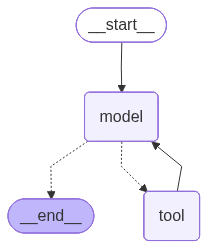

In [28]:
from langgraph.graph import StateGraph, MessagesState, START, END

class NewState(MessagesState):
    pass

def model_node(state: NewState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def is_done(state: NewState) -> bool:
    last_message = state["messages"][-1]
    if last_message.tool_calls: 
        return "tool"
    return END

graph_builder = StateGraph(NewState)
graph_builder.add_node("model", model_node)
graph_builder.add_node("tool", tool_node)
graph_builder.add_edge(START, "model")
# THIS IS THE IMPORTANT PART
graph_builder.add_conditional_edges(
    "model",
    is_done,
    [END, "tool"]
)
# Reverse edge:
graph_builder.add_edge("tool", "model")

graph = graph_builder.compile()
display_graph(graph)

In [29]:
question = "If I split a $200 bill among 4 people with a 20% tip, how much does each person pay?. Do not perform any calculations on your own, use evaluate_expression tool when required."
result = graph.invoke({"messages": [question]})
for i, message in enumerate(result['messages']):
    print(f"Message {i+1}: {message}")
print("Total messages: ", len(result['messages']))

print("------FINAL RESULT------")
print(result['messages'][-1].content)

Message 1: content='If I split a $200 bill among 4 people with a 20% tip, how much does each person pay?. Do not perform any calculations on your own, use evaluate_expression tool when required.' additional_kwargs={} response_metadata={} id='22e6bb17-6190-4ad8-8439-802689c8c03c'
Message 2: content='' additional_kwargs={'tool_calls': [{'id': 'call_o8aLVNDPrx5ppKwqu98TwcZZ', 'function': {'arguments': '{"expression":"200 * (1 + 0.20)"}', 'name': 'evaluate_expression'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 480, 'prompt_tokens': 171, 'total_tokens': 651, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 448, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CUTQ5Z30fjPXJU8tHTqgSUwFlUx0o', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logp

In [30]:
# All of the above code can be done in a SINGLE LINE:
from langgraph.prebuilt import create_react_agent

llm = init_chat_model("gpt-5-mini", model_provider="openai", reasoning_effort="minimal")
graph = create_react_agent(llm, tools=[evaluate_expression])

question = "If I split a $200 bill among 4 people with a 20% tip, how much does each person pay?"
display_graph(graph)

In [31]:
result = graph.invoke({"messages": [question]})
for message in result['messages']:
    print(type(message), message)

<class 'langchain_core.messages.human.HumanMessage'> content='If I split a $200 bill among 4 people with a 20% tip, how much does each person pay?' additional_kwargs={} response_metadata={} id='829972ed-a204-42a9-881a-24d15a86ad16'
<class 'langchain_core.messages.ai.AIMessage'> content='' additional_kwargs={'tool_calls': [{'id': 'call_5ZcMKTQwgMs5Uj3X3E07nV4Q', 'function': {'arguments': '{"expression":"200 * 1.20 / 4"}', 'name': 'evaluate_expression'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 155, 'total_tokens': 186, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CUTSk4EbxMEHftbNFXdyg8vjXleeJ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='

### Why bother building a graph?
While the ReAct agent pattern exists, LangGraph allows you to build more complex agents with more control over the loop/flow.

Refer to https://langchain-ai.github.io/langgraph/prebuilt/ to learn more about pre-built agents and community agent libraries.


#### Model Recommendations
We recommend using GPT-4o for agent assignments instead of GPT-4o-mini. When working with agents and tools, smaller models are unable to use the tool correctly sometimes. This'd incur more iterations to get the right answer.

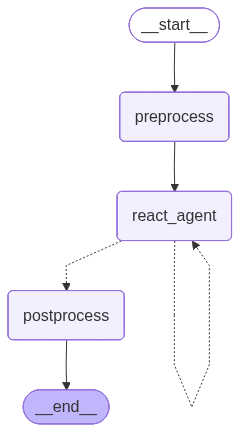

In [32]:
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool

# Define our tool
@tool
def evaluate_expression(expression: str) -> float:
    """Evaluate a valid mathematical expression in Python and return the result."""
    return str(eval(expression))

# Initialize LLM
llm = init_chat_model("gpt-5-mini", model_provider="openai", reasoning_effort="minimal")

# Create a react agent as a standalone component
react_agent = create_react_agent(llm, tools=[evaluate_expression])

# Create our custom state
class WorkflowState(MessagesState):
    """State for our workflow."""
    preprocessing_result: str = ""
    final_result: str = ""

# Define nodes for our graph
def preprocess_node(state: WorkflowState):
    """Preprocess the input query to standardize it."""
    messages = state["messages"]
    # Extract the user query from messages
    user_query = messages[-1].content
    
    # Simple preprocessing: Add a standard prefix
    preprocessed_query = f"I need to calculate the following: {user_query}"
    
    return {"preprocessing_result": preprocessed_query, "messages": [preprocessed_query]}

def react_agent_node(state: WorkflowState):
    """Use the react agent to solve the problem."""
    # Get the preprocessed query and pass it to the react agent
    input_message = state["messages"][-1]
    
    # Invoke the react agent with the preprocessed query
    result = react_agent.invoke({"messages": [input_message]})
    
    # Return the agent's response
    return {"messages": result["messages"]}

def postprocess_node(state: WorkflowState):
    """Format the final response from the agent."""
    agent_response = state["messages"][-1].content
    
    # Simple postprocessing: Format the answer nicely
    final_answer = f"FINAL ANSWER: {agent_response}"
    
    return {"final_result": final_answer}

# Function to determine if we're done
def should_end(state: WorkflowState):
    """Check if there's useful content in messages."""
    print(f"Messages in should_end")
    for message in state["messages"]:
        print(type(message), message)
    if state["messages"] and len(state["messages"]) >= 2:
        return "postprocess"
    # This doesn't happen unless there react_agent_node is called
    # but the messages are not returned correctly.
    return "react_agent"

# Build the graph
workflow_builder = StateGraph(WorkflowState)
workflow_builder.add_node("preprocess", preprocess_node)
workflow_builder.add_node("react_agent", react_agent_node)
workflow_builder.add_node("postprocess", postprocess_node)

# Define the edges
workflow_builder.add_edge(START, "preprocess")
workflow_builder.add_edge("preprocess", "react_agent")
workflow_builder.add_conditional_edges("react_agent", should_end, 
                                    {"react_agent": "react_agent", "postprocess": "postprocess"})
workflow_builder.add_edge("postprocess", END)

# Compile the graph
workflow = workflow_builder.compile()

# Display the graph
display_graph(workflow)

In [33]:
# Test the workflow
question = "If I split a $200 bill among 4 people with a 20% tip, how much does each person pay?"
result = workflow.invoke({"messages": [question]})
print("Input:", question)
print("\nPreprocessed:", result["preprocessing_result"])
print("\nFinal Result:", result["final_result"])

Messages in should_end
<class 'langchain_core.messages.human.HumanMessage'> content='If I split a $200 bill among 4 people with a 20% tip, how much does each person pay?' additional_kwargs={} response_metadata={} id='350b9b9b-125a-4117-9f8a-c7ad74dbb109'
<class 'langchain_core.messages.human.HumanMessage'> content='I need to calculate the following: If I split a $200 bill among 4 people with a 20% tip, how much does each person pay?' additional_kwargs={} response_metadata={} id='8e793251-e9a4-4df0-9357-875124d7c3e2'
<class 'langchain_core.messages.ai.AIMessage'> content='' additional_kwargs={'tool_calls': [{'id': 'call_3AV0EnqJNYE46yCou1tST9xp', 'function': {'arguments': '{"expression":"200 * 1.20 / 4"}', 'name': 'evaluate_expression'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 162, 'total_tokens': 193, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejec

## Monitoring and Tracing with Comet Opik

Comet Opik is a great tool for monitoring and tracing LangGraph workflows. Building with Agents make it even more necessary to monitor and trace the workflow. Otherwise, it becomes a black box, an expensive black box!!

In [35]:
print(os.environ["OPIK_API_KEY"][:10])
print(os.environ["OPIK_WORKSPACE"])
print(os.environ["OPIK_PROJECT_NAME"])

SrPHJq9M93
saikiriti93
Langgraph Demo Project


In [36]:
from opik.integrations.langchain import OpikTracer

# Track the graph structure:
tracer = OpikTracer(graph=graph.get_graph(xray=True))
inputs = {"messages": "What is the sum of characters in the capital of Germany and India? Don't perform any calcualtions on your own. Use evaluate_expression tool when required to do any calculations."}

# Trace the invocation for a particular input:
# The use of tracer is optional for each invocation.
result = graph.invoke(inputs, config={"callbacks": [tracer]})
print(result['messages'][-1].content)

15


In [ ]:
inputs = {"messages": "If I split a $200 bill among 4 people with a 20% tip, how much does each person pay?"}
result = graph.invoke(inputs, config={"callbacks": [tracer]})
print(result['messages'][-1].content)